In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
sys.path.append('/home/gferro/PhaseAmplification/')

In [4]:
from qat.core.console import display
from qat.qpus import LinAlg

In [5]:
from dataloading_module import  CreateLoadFunctionGate, CreatePG
from kk import get_histogram

In [6]:
#Probability function
def p(x):
    return x*x

def f(x):
    return np.sin(x)

# Algoritmo de Amplificación de Amplitud

Tenemos todos los bloques necesarios para implementar la primera parte del algoritmo de amplificación de amplitud:

1. Carga de Proabilidades
2. Carga de Función a integrar
3. Operador $\hat{U}_{|\Psi_0\rangle}$
4. Operador $\hat{D}_{0}$

Nos queda implementar el operador $\hat{U}_{|\Psi_2\rangle} = \hat{R_{n+1}}\hat{P_{n}}\hat{D}_{0} \hat{P_{n}}^{\dagger} \hat{R_{n+1}}^{\dagger}$

In [7]:
from qat.lang.AQASM import AbstractGate, QRoutine, X, Z
def Reflexion_generator(N):
    """
    Implementa una reflexion en torno al estado |\Phi_0>: I-2|\Phi_0><Phi_0|
    """
    qrout = QRoutine()
    qbits = qrout.new_wires(N)
    qrout.apply(X, qbits[-1])
    qrout.apply(Z, qbits[-1])
    qrout.apply(X, qbits[-1])
    
    return qrout#-Zeroes
UPhi_0 = AbstractGate("UPhi_0", [int])
UPhi_0.set_circuit_generator(Reflexion_generator)

def Reflexion_generator0(N):
    """
    Implementa una reflexion en torno al estado 0: I-2|0><0|
    """
    qrout = QRoutine()
    qbits = qrout.new_wires(N)
    for i in range(N):
        qrout.apply(X, qbits[i])
    #Controlled Z gate by n-1 first qbits
    cZ = 'Z'+ '.ctrl()'*(len(qbits)-1)
    qrout.apply(eval(cZ), qbits[:-1], qbits[-1])
    for i in range(N):
        qrout.apply(X, qbits[i])
    
    return qrout#-Zeroes
D_0 = AbstractGate("D_0", [int])
D_0.set_circuit_generator(Reflexion_generator0)

def LoadDifusorGate(N, ProbabilityArray, FunctionArray):
    from dataloading_module import  CreateLoadFunctionGate, CreatePG
    P_gate = CreatePG(ProbabilityArray)
    R_gate = CreateLoadFunctionGate(FunctionArray)
    def Difusor(nqbits):
        qrout = QRoutine()
        qbits = qrout.new_wires(nqbits)
        qrout.apply(P_gate, qbits[:-1])
        qrout.apply(R_gate, qbits)
        qrout.apply(D_0(nqbits), qbits)
        qrout.apply(R_gate.dag(), qbits)
        qrout.apply(P_gate.dag(), qbits[:-1])
        return qrout
    UPhi_2 = AbstractGate("UPhi_2", [int])
    UPhi_2.set_circuit_generator(Difusor)
    return UPhi_2(N)



In [ ]:
def DoCircuit(nqbits = 4, Reflexion = True):
    from qat.lang.AQASM import Program
    nbins = 2**nqbits
    a = 0
    b = 1
    #Discretization for the function domain
    centers, probs = get_histogram(p, a, b, nbins)
    #Discretizated function to load 
    DiscretizedFunction = f(centers) 
    #Quantum Program
    qprog = Program()
    qbits = qprog.qalloc(nqbits+1)
    #Create Probability loading gate
    P_gate = CreatePG(probs)
    qprog.apply(P_gate, qbits[:-1])
    #Create Function loading gate
    R_gate = CreateLoadFunctionGate(DiscretizedFunction)    
    qprog.apply(R_gate, qbits)    
    difusor = LoadDifusorGate(nqbits+1, probs, DiscretizedFunction)
    if Reflexion:
        qprog.apply(difusor, qbits) 
    #Create the circuit from the program
    circuit = qprog.to_circ()
    job = circuit.to_job()
    #Import and create the linear algebra simulator
    linalgqpu = LinAlg()
    #Submit the job to the simulator LinAlg and get the results
    result = linalgqpu.submit(job)
    QP = []
    States = []
    QA = []
    #Print the results
    for sample in result:
        #print("State %s probability %s amplitude %s" % (sample.state, sample.probability, sample.amplitude))
        QP.append(sample.probability)
        States.append(str(sample.state))
        QA.append(sample.amplitude)
    QP = pd.Series(QP, name='Probability')  
    States = pd.Series(States, name='States')  
    QA = pd.Series(QA, name='Amplitude') 
    pdf = pd.concat([States, QP, QA], axis=1)
    return pdf, circuit

In [ ]:
pdfNotReflexion, circuitNR = DoCircuit(Reflexion=False)
pdfReflexion, circuitR = DoCircuit()

In [ ]:
%qatdisplay circuitR --depth 0

In [ ]:
%qatdisplay circuitNR --depth 0

## Operador Amplificacion

In [8]:
def LoadGroverAmplification(N, ProbabilityArray, FunctionArray):
    difusor = LoadDifusorGate(N, ProbabilityArray, FunctionArray)
    def Grover(N):
        qrout = QRoutine()
        qbits = qrout.new_wires(N)   
        qrout.apply(UPhi_0(N), qbits)
        qrout.apply(difusor, qbits)
        return qrout
    Q = AbstractGate("Q", [int])
    Q.set_circuit_generator(Grover)    
    return Q(N)

In [30]:
def DoCircuit(nqbits = 4, Reflexion = True):
    from qat.lang.AQASM import Program
    nbins = 2**nqbits
    a = 0
    b = 1
    
    #Discretization for the function domain
    centers, probs = get_histogram(p, a, b, nbins)
    #Create Probability loading gate
    P_gate = CreatePG(probs)    

    #Discretizated function to load 
    DiscretizedFunction = f(centers) 
    #Create Function loading gate    
    R_gate = CreateLoadFunctionGate(DiscretizedFunction)    
    
    #Load Amplification Gates
    Q = LoadGroverAmplification(nqbits+1, probs, DiscretizedFunction)
    difusor = LoadDifusorGate(nqbits+1, probs, DiscretizedFunction)
    
    #Quantum Program
    qprog = Program()
    qbits = qprog.qalloc(nqbits+1)
    qprog.apply(P_gate, qbits[:-1])
    qprog.apply(R_gate, qbits)    
    #qprog.apply(UPhi_0(nqbits+1), qbits) 
    if Reflexion:
        #pass
        for i in range(1):
            qprog.apply(Q, qbits)
    #Create the circuit from the program
    circuit = qprog.to_circ()
    linalgqpu = LinAlg()
    """
    job = circuit.to_job()
    #Import and create the linear algebra simulator
    linalgqpu = LinAlg()
    #Submit the job to the simulator LinAlg and get the results
    result = linalgqpu.submit(job)    
    """

    
    
    result = linalgqpu.submit(
        circuit.to_job(qubits = [0])
    )
    
    
    QP = []
    States = []
    QA = []
    #Print the results
    for sample in result:
        #print("State %s probability %s amplitude %s" % (sample.state, sample.probability, sample.amplitude))
        QP.append(sample.probability)
        States.append(str(sample.state))
        QA.append(sample.amplitude)
    QP = pd.Series(QP, name='Probability')  
    States = pd.Series(States, name='States')  
    QA = pd.Series(QA, name='Amplitude') 
    pdf = pd.concat([States, QP, QA], axis=1)
    return pdf, circuit

In [31]:
pdfReflexion, circuitR = DoCircuit()
pdfNotReflexion, circuitNR = DoCircuit(Reflexion=False)

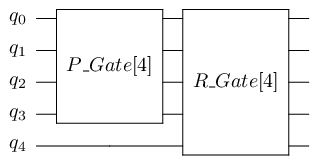

In [32]:
%qatdisplay circuitNR --depth 0

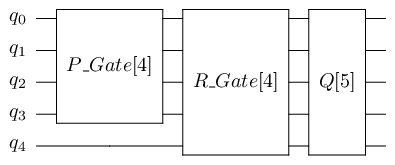

In [33]:
%qatdisplay circuitR --depth 0

In [36]:
pdfNotReflexion

,States,Probability,Amplitude
0,|0>,0.124633,None
1,|1>,0.875367,None


In [35]:
pdfReflexion

,States,Probability,Amplitude
0,|0>,0.127453,None
1,|1>,0.872547,None


In [ ]:
%qatdisplay circuitR --depth 0

In [ ]:
pdfReflexion

In [ ]:
pdfReflexion

In [ ]:
sum(pdfNotReflexion[pdfNotReflexion['States'].str.extract(r'(\d)>')[0]=='1']['Probability'])

In [ ]:
sum(pdfReflexion[pdfReflexion['States'].str.extract(r'(\d)>')[0]=='1']['Probability'])

In [ ]:
pdfReflexion[pdfReflexion['States'].str.extract(r'(\d)>')[0]=='1']

In [ ]:
pdfNotReflexion[pdfNotReflexion['States'].str.extract(r'(\d)>')[0]=='1']